In [254]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.impute import KNNImputer
from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr, skew
from itertools import combinations


Final

In [257]:
class DataCleaner:
    def __init__(self, df):
        self._df = df
        self.issues = self._detect_issues()
        self._print_issues()
        self.methods = [
            "Median + Most Frequent",
            "KNN Imputation",
            "Outlier Removal with Median Imputation",
            "Outlier Removal Ignoring Missing",
            "Outlier Removal",
        ]

    @property
    def df(self):
        return self._df

    @df.setter
    def df(self, new_df):
        self._df = new_df
        self.issues = self._detect_issues()
        self._print_issues()

    def _print_issues(self):
        if self.issues:
            print("Issues detected:")
            for issue in self.issues:
                print(" -", issue)
        else:
            print("No issues detected. The data is clean.")

    def _detect_issues(self):
        issues = []
        # Check for missing values
        if self.df.isnull().sum().sum() > 0:
            issues.append("Missing values detected.")
        # Check for duplicate rows
        if self.df.duplicated().sum() > 0:
            issues.append("Duplicate rows detected.")
        # Check for incorrect data types
        for col in self.df.columns:
            if self.df[col].dtype == object:
                try:
                    pd.to_numeric(self.df[col])
                    issues.append(f"Incorrect data type in column {col}.")
                except ValueError:
                    pass
        # Check for outliers
        numeric_cols = self.df.select_dtypes(include=[np.number])
        if not numeric_cols.empty:
            z_scores = np.abs(stats.zscore(numeric_cols))
            if np.any(z_scores > 3):
                issues.append("Outliers detected.")
        # Check for high cardinality in categorical variables
        for col in self.df.select_dtypes(include=["object"]):
            if self.df[col].nunique() > 10:  # Adjust threshold based on use case
                issues.append(f"High cardinality in column {col}.")
        return issues

    def apply_cleaning_method(self, df, method):
        cleaned_df = deepcopy(df)

        if method == "Median + Most Frequent":
            # Median for Numerical Columns, Most Frequent for Categorical Columns
            for col in cleaned_df.select_dtypes(include=[np.number]):
                if cleaned_df[col].isnull().sum() > 0:
                    cleaned_df[col].fillna(cleaned_df[col].median(), inplace=True)
            for col in cleaned_df.select_dtypes(include=["object"]):
                if cleaned_df[col].isnull().sum() > 0:
                    cleaned_df[col].fillna(cleaned_df[col].mode()[0], inplace=True)

        elif method == "KNN Imputation":
            # KNN Imputation for Numerical Columns
            imputer = KNNImputer(n_neighbors=5)
            numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns
            imputed_data = imputer.fit_transform(cleaned_df[numeric_columns])
            cleaned_df[numeric_columns] = imputed_data

        elif method == "Outlier Removal with Median Imputation":
            # Fill missing values with median then remove outliers
            for col in cleaned_df.select_dtypes(include=[np.number]):
                if cleaned_df[col].isnull().sum() > 0:
                    cleaned_df[col].fillna(cleaned_df[col].median(), inplace=True)
            numeric_columns = cleaned_df.select_dtypes(include=[np.number])
            z_scores = np.abs(stats.zscore(numeric_columns))
            cleaned_df = cleaned_df[(z_scores < 3).all(axis=1)]

        elif method == "Outlier Removal Ignoring Missing":
            # Remove outliers, but only consider rows without missing values in numeric columns
            numeric_columns = cleaned_df.select_dtypes(include=[np.number])
            non_missing_rows = numeric_columns.dropna()
            z_scores = np.abs(stats.zscore(non_missing_rows))
            non_missing_mask = (z_scores < 3).all(axis=1)
            cleaned_df = cleaned_df.loc[non_missing_rows.index[non_missing_mask]]

        elif method == "Outlier Removal":
            # Handle missing values before calculating z-scores
            numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns
            for col in numeric_columns:
                if cleaned_df[col].isnull().sum() > 0:
                    cleaned_df[col].fillna(cleaned_df[col].median(), inplace=True)
            z_scores = np.abs(stats.zscore(cleaned_df[numeric_columns]))
            cleaned_df = cleaned_df[(z_scores < 3).all(axis=1)]

        return cleaned_df

    def _calculate_interestingness(self, df, col1, col2):
        return abs(df[col1].corr(df[col2]))

    def visualize_effect_of_methods(self):
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) < 2:
            print("Not enough numeric columns for scatterplot visualization.")
            return

        x_col, y_col = numeric_cols[:2]
        cleaned_dfs = []
        for method in self.methods:
            cleaned_df = self.apply_cleaning_method(self.df, method)
            interestingness = self._calculate_interestingness(cleaned_df, x_col, y_col)
            cleaned_dfs.append((cleaned_df, method, interestingness))

        cleaned_dfs.sort(key=lambda x: x[2], reverse=True)  # Sort by interestingness

        # Prune visuals with similar interestingness
        pruned_dfs = []
        prev_interestingness = None
        for cleaned_df, method, interestingness in cleaned_dfs:
            if prev_interestingness is not None and abs(prev_interestingness - interestingness) < 0.01:  # Adjust threshold as needed
                continue  # Skip this visualization if the interestingness score is too similar to the previous one
            pruned_dfs.append((cleaned_df, method, interestingness))
            prev_interestingness = interestingness

        num_visuals = len(pruned_dfs)
        fig, axes = plt.subplots(1, num_visuals, figsize=(num_visuals * 5, 5))

        for i, (cleaned_df, method, interestingness) in enumerate(pruned_dfs):
            ax = axes[i] if num_visuals > 1 else axes
            sns.scatterplot(x=cleaned_df[x_col], y=cleaned_df[y_col], ax=ax)
            ax.set_title(f"{method} - {x_col} vs {y_col}\nInterestingness: {interestingness:.3f}")
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)

        plt.tight_layout()
        plt.show()
        
    def visualize_all_methods(self):
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) < 2:
            print("Not enough numeric columns for scatterplot visualization.")
            return

        x_col, y_col = numeric_cols[:2]
        cleaned_dfs = []
        for method in self.methods:
            cleaned_df = self.apply_cleaning_method(self.df, method)
            interestingness = self._calculate_interestingness(cleaned_df, x_col, y_col)
            cleaned_dfs.append((cleaned_df, method, interestingness))

        num_visuals = len(cleaned_dfs)
        fig, axes = plt.subplots(1, num_visuals, figsize=(num_visuals * 5, 5))

        for i, (cleaned_df, method, interestingness) in enumerate(cleaned_dfs):
            ax = axes[i] if num_visuals > 1 else axes
            sns.scatterplot(x=cleaned_df[x_col], y=cleaned_df[y_col], ax=ax)
            ax.set_title(f"{method} - {x_col} vs {y_col}\nInterestingness: {interestingness:.3f}")
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)

        plt.tight_layout()
        plt.show()

## Example Usage:
##### 1. Load the Dataset: Load your dataset into a DataFrame.
##### 2. Create an Instance of DataCleaner: Create an instance of the DataCleaner class with your DataFrame.
##### 3. Visualize the Effect of Cleaning Methods: Call the visualize_effect_of_methods function to see the effect of different cleaning methods on the most interesting pairs of columns.
##### 4. Visualize the Effect of All Cleaning Methods: Call the visualize_all_methods function to see the effect of different cleaning methods regardless of interestingness. 

# US Census Dataset

In [264]:
#Load your dataset
df = pd.read_csv('/Users/rachit/Desktop/Fall 2023/CS 8803 - MDS/Progress Report 1/data/USCensus/raw/raw.csv')
df2=df.iloc[:500]

In [265]:
#detect issues
data_cleaner = DataCleaner(df2)

Issues detected:
 - Missing values detected.
 - Outliers detected.
 - High cardinality in column Education.
 - High cardinality in column Occupation.
 - High cardinality in column Native-country.


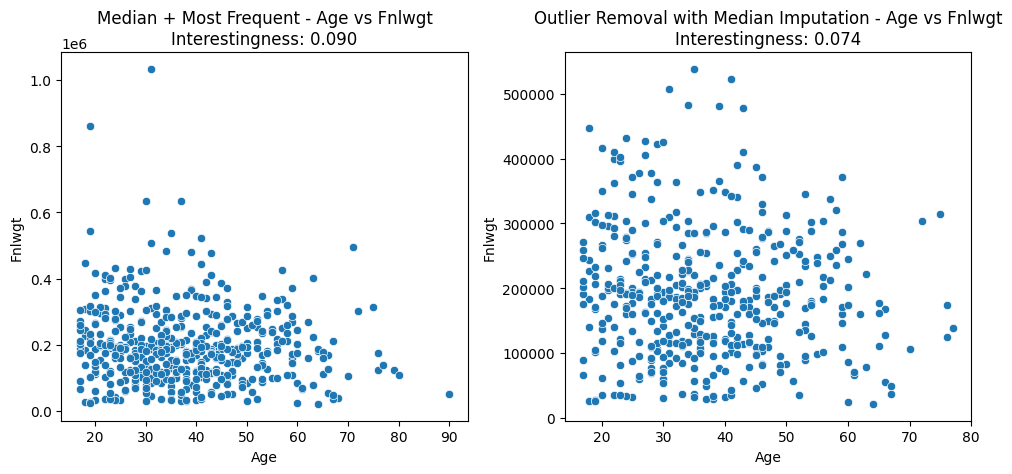

In [266]:
# Visualize based on interestingness (sorted Descending)
data_cleaner.visualize_effect_of_methods()

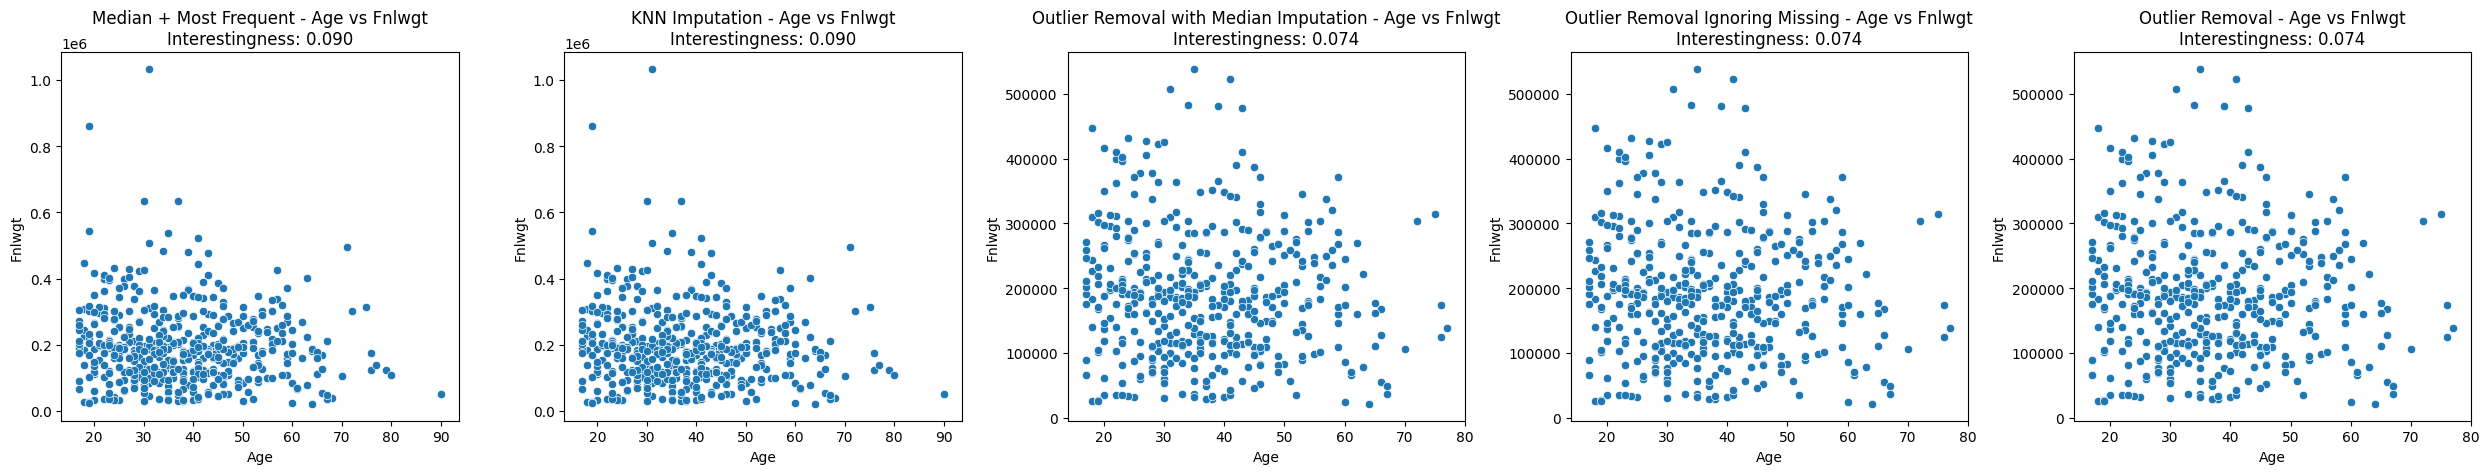

In [267]:
# Visualize All cleaning methods regardless of interestingness (sorted Descending)
data_cleaner.visualize_all_methods()

# EEG Dataset with Outliers

In [271]:
#Load your dataset
df = pd.read_csv('/Users/rachit/Desktop/Fall 2023/CS 8803 - MDS/Progress Report 1/data/EEG/raw/raw.csv')
df2=df.iloc[:500]

In [272]:
#detect issues
data_cleaner = DataCleaner(df2)

Issues detected:
 - Outliers detected.


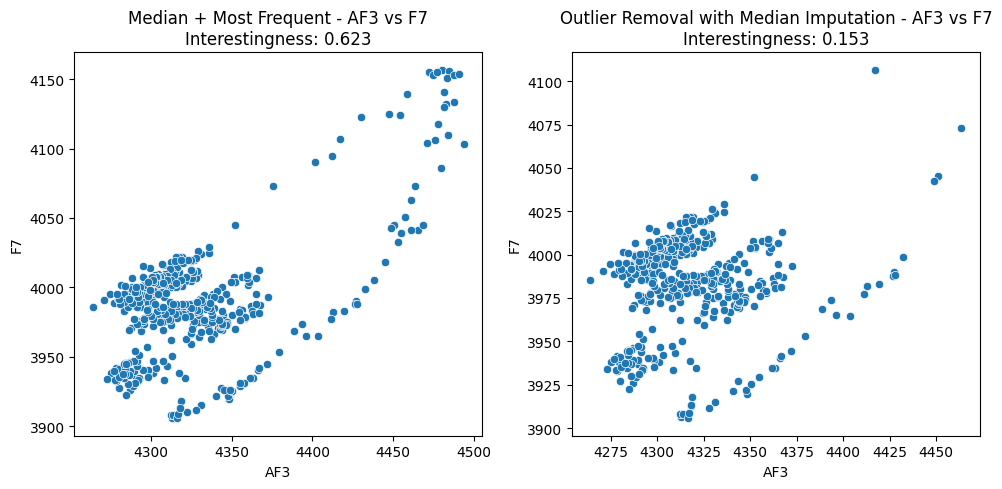

In [273]:
# Visualize based on interestingness (sorted Descending)
data_cleaner.visualize_effect_of_methods()

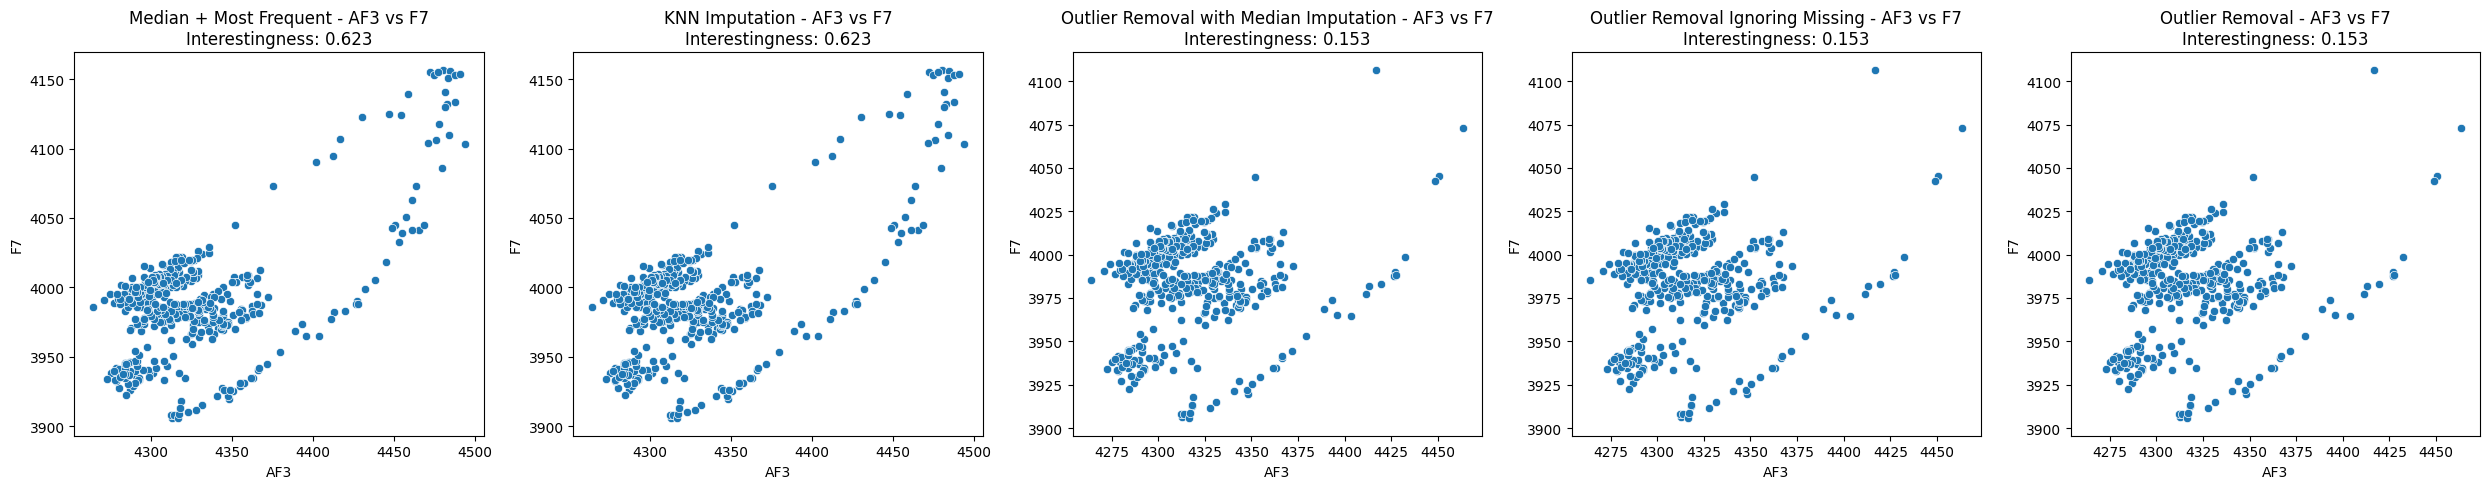

In [274]:
# Visualize All cleaning methods regardless of interestingness (sorted Descending)
data_cleaner.visualize_all_methods()